# Largest Threads: USDM - 2015

a. stein 5.4.2023

In [1]:
import pickle
import numpy as np

import sys
sys.path.append('../../../')
import ndrought.drought_network_v12 as dnet
import ndrought.wrangle_v11 as dnw

import matplotlib as mpl
import matplotlib.pyplot as plt

import pandas as pd
import xarray as xr

from tqdm.autonotebook import tqdm
import geopandas as gpd

/pool0/data/steinjao/drought/drought_impact/notebooks/analysis/drought_threads/../../../ndrought/wrangle.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
dnet_path = '/pool0/home/steinadi/data/drought/drought_impact/data/drought_measures/ndrought_products/CONUS_105W/individual_dnet'

In [3]:
exp_tag = 'f25k_d1_rt20p_paired'

In [4]:
usdm_net = dnet.DroughtNetwork.unpickle(f'{dnet_path}/USDM_net_{exp_tag}.pickle')

In [5]:
spi30d_net = dnet.DroughtNetwork.unpickle(f'{dnet_path}/spi_30d_net_{exp_tag}.pickle')

In [6]:
spi180d_net = dnet.DroughtNetwork.unpickle(f'{dnet_path}/spi_180d_net_{exp_tag}.pickle')

In [7]:
paired_ds = xr.open_dataset('/pool0/home/steinadi/data/drought/drought_impact/data/drought_measures/ndrought_products/CONUS_105W/paired_ds/usdm_spi_paired.nc')

## Largest USDM

In [8]:
largest_id = 0
largest_size = 0

for node in usdm_net.nodes:
    if len(node.coords) > largest_size:
        largest_id = node.id
        largest_size = len(node.coords)

usdm_ln = usdm_net.nodes[largest_id]
usdm_ln

time: 1125, id: 1790

In [9]:
paired_ds['USDM Date'].sel(index=1125).values

numpy.datetime64('2021-07-27T00:00:00.000000000')

Okay, that's pretty close to the end of the record ... let's try to find one instead that's somewhere else.

In [10]:
largest_id = 0
largest_size = 0

for node in usdm_net.nodes:
    # pull out during 2014-2016
    if node.time > 765 and node.time < 870:
        if len(node.coords) > largest_size:
            largest_id = node.id
            largest_size = len(node.coords)

usdm_ln = usdm_net.nodes[largest_id]
usdm_ln

time: 810, id: 1192

In [11]:
paired_ds['USDM Date'].sel(index=810).values

numpy.datetime64('2015-07-14T00:00:00.000000000')

In [12]:
intersect_time = paired_ds['USDM Date'].sel(index=810).values

that'll do

In [13]:
usdm_ln_cs = set(tuple(coord) for coord in usdm_ln.coords)

In [14]:
spi30d_tm = []

for node in spi30d_net:
    if node.time == usdm_ln.time:
        print(node)
        spi30d_tm.append(node)

time: 810, id: 1573, futures: [1575]
time: 810, id: 1574, futures: [1575]


In [15]:
spi30d_tracer_nodes = []
for node in spi30d_tm:
    node_cs = set(tuple(coord) for coord in node.coords)
    intersect = len(usdm_ln_cs.intersection(node_cs))
    print(intersect)
    if intersect > 0:
        spi30d_tracer_nodes.append(node)

13550
7735


In [16]:
spi180d_tm = []

for node in spi180d_net:
    if node.time == usdm_ln.time:
        print(node)
        spi180d_tm.append(node)

time: 810, id: 1241, futures: [1243]
time: 810, id: 1242, futures: [1244]


In [17]:
spi180d_tracer_nodes = []

for node in spi180d_tm:
    node_cs = set(tuple(coord) for coord in node.coords)
    intersect = len(usdm_ln_cs.intersection(node_cs))
    print(intersect)
    if intersect > 0: 
        spi180d_tracer_nodes.append(node)

8314
1481


In [18]:
usdm_trace = usdm_net.get_full_thread([usdm_ln])

In [19]:
spi30d_trace = spi30d_net.get_full_thread(nodes=spi30d_tracer_nodes)

In [20]:
spi180d_trace = spi180d_net.get_full_thread(nodes=spi180d_tracer_nodes)

In [21]:
usdm_spi30d_on = dnet.overlap_nodes(usdm_trace, spi30d_trace)

  0%|          | 0/657 [00:00<?, ?it/s]

In [22]:
usdm_spi180d_on = dnet.overlap_nodes(usdm_trace, spi180d_trace)

  0%|          | 0/657 [00:00<?, ?it/s]

In [23]:
spi30d_spi180d_on = dnet.overlap_nodes(spi30d_trace, spi180d_trace)

  0%|          | 0/34 [00:00<?, ?it/s]

In [24]:
aa_usdm_spi30d = dnet.compute_alignment_area(usdm_spi30d_on)

In [25]:
aa_usdm_spi180d = dnet.compute_alignment_area(usdm_spi180d_on)

In [26]:
aa_spi30d_spi180d = dnet.compute_alignment_area(spi30d_spi180d_on)

In [27]:
da_usdm_spi30d, da_spi30d_usdm = dnet.compute_disagreement_area(usdm_net, spi30d_net, usdm_spi30d_on)

In [28]:
da_usdm_spi180d, da_spi180d_usdm = dnet.compute_disagreement_area(usdm_net, spi180d_net, usdm_spi180d_on)

In [29]:
da_spi30d_spi180d, da_spi180d_spi30d = dnet.compute_disagreement_area(spi30d_net, spi180d_net, spi30d_spi180d_on)

In [30]:
usdm_times = [node.time for node in spi30d_trace]
start_time = np.min(usdm_times)
end_time = np.max(usdm_times)

In [31]:
usdm_array = usdm_net.node_array(usdm_trace, start_time, end_time)

In [32]:
usdm_array.shape

(20, 702, 525)

In [33]:
spi30d_array = spi30d_net.node_array(spi30d_trace, start_time, end_time)

In [34]:
spi180d_array = spi180d_net.node_array(spi180d_trace, start_time, end_time)

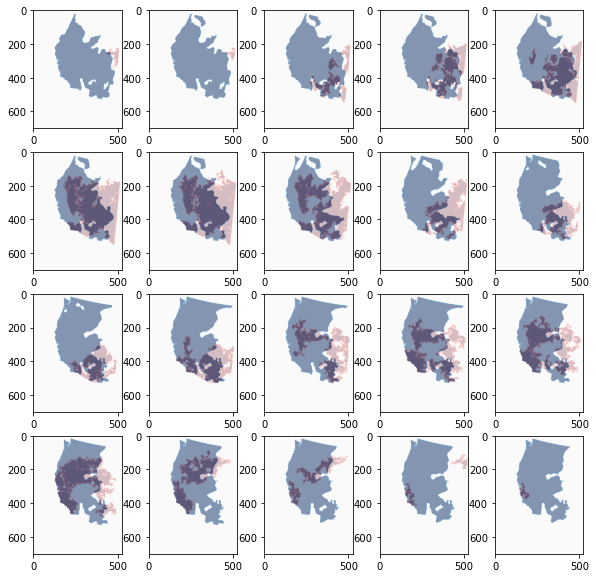

In [35]:
fig, axs = plt.subplots(4,5, figsize=(10,10))

for i, ax in enumerate(axs.ravel()):
    ax.imshow(spi30d_array[i, :, :], alpha=0.5, cmap=plt.cm.get_cmap('Reds'))
    ax.imshow(usdm_array[i, :, :], alpha=0.5, cmap=plt.cm.get_cmap('Blues'))

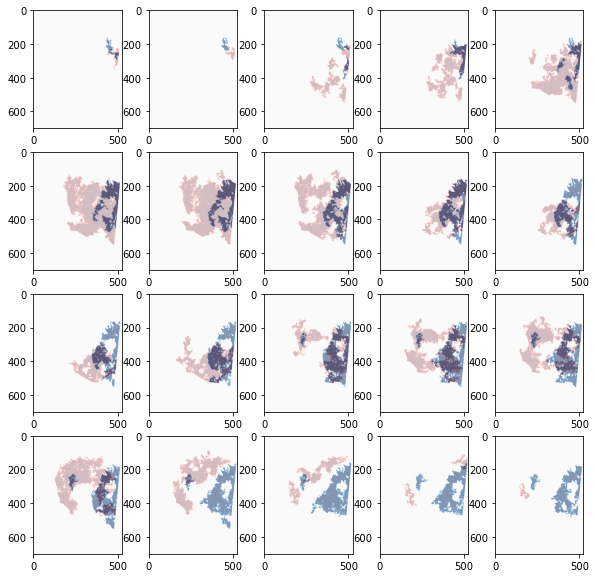

In [36]:
fig, axs = plt.subplots(4,5, figsize=(10,10))

for i, ax in enumerate(axs.ravel()):
    ax.imshow(spi30d_array[i, :, :], alpha=0.5, cmap=plt.cm.get_cmap('Reds'))
    ax.imshow(spi180d_array[i, :, :], alpha=0.5, cmap=plt.cm.get_cmap('Blues'))

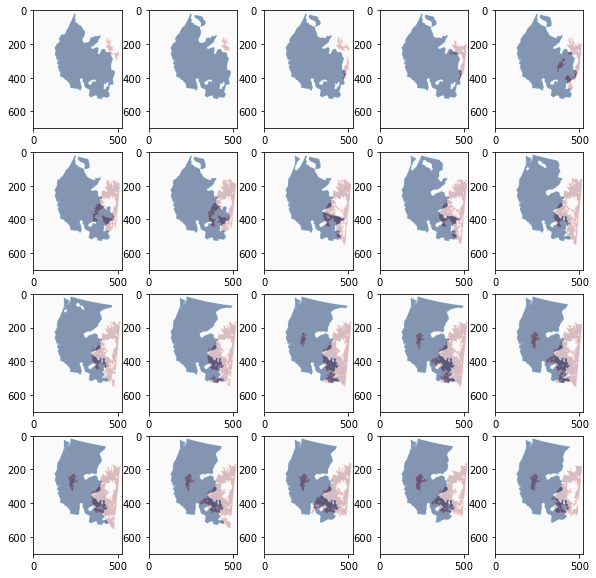

In [37]:
fig, axs = plt.subplots(4,5, figsize=(10,10))

for i, ax in enumerate(axs.ravel()):
    ax.imshow(spi180d_array[i, :, :], alpha=0.5, cmap=plt.cm.get_cmap('Reds'))
    ax.imshow(usdm_array[i, :, :], alpha=0.5, cmap=plt.cm.get_cmap('Blues'))

In [38]:
usdm_array.shape

(20, 702, 525)

In [39]:
df = gpd.read_file('/pool0/home/steinjao/data/drought/drought_impact/data/geometry/tl_2022_us_state.shp')
df.to_crs("EPSG:4326");
non_continental = ['HI','VI','MP','GU','AK','AS','PR']
us49 = df
for n in non_continental:
    us49 = us49[us49.STUSPS != n]

In [40]:
usdm_array_da = xr.DataArray(
    usdm_array,
    dims = ['t', 'y', 'x'],
    coords = dict(
        x=paired_ds.x.values,
        y=paired_ds.y.values,
        t=paired_ds['USDM Date'].sel(index=slice(start_time, end_time)).values
    )
).rio.set_crs('EPSG:5070')
usdm_array_da = usdm_array_da.rio.reproject('EPSG:4326', nodata=0)
#usdm_array_da

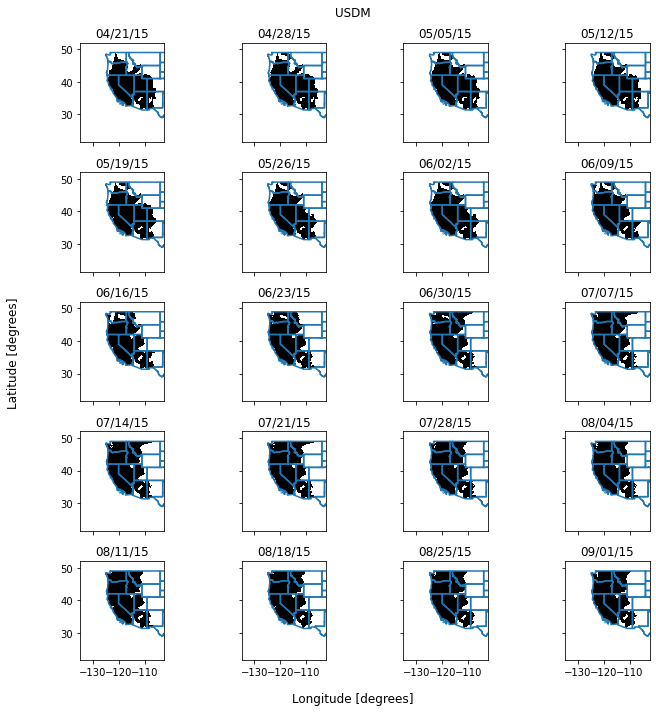

In [58]:
fig, axs = plt.subplots(5,4, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axs.ravel()):
    usdm_array_da.isel(t=i).plot(ax=ax, cmap='Greys', add_colorbar=False)
    ax.set_title(pd.to_datetime(usdm_array_da['t'].values[i]).strftime('%D'))
    ax.set_xlabel('')
    ax.set_ylabel('')
    us49.boundary.plot(ax=ax)
fig.supylabel('Latitude [degrees]')
fig.supxlabel('Longitude [degrees]')
fig.suptitle('USDM')
fig.set_facecolor('w')
plt.tight_layout()

In [42]:
spi30d_array_da = xr.DataArray(
    spi30d_array,
    dims = ['t', 'y', 'x'],
    coords = dict(
        x=paired_ds.x.values,
        y=paired_ds.y.values,
        t=paired_ds['SPI Date'].sel(index=slice(start_time, end_time)).values
    )
).rio.set_crs('EPSG:5070')
spi30d_array_da = spi30d_array_da.rio.reproject('EPSG:4326', nodata=0)

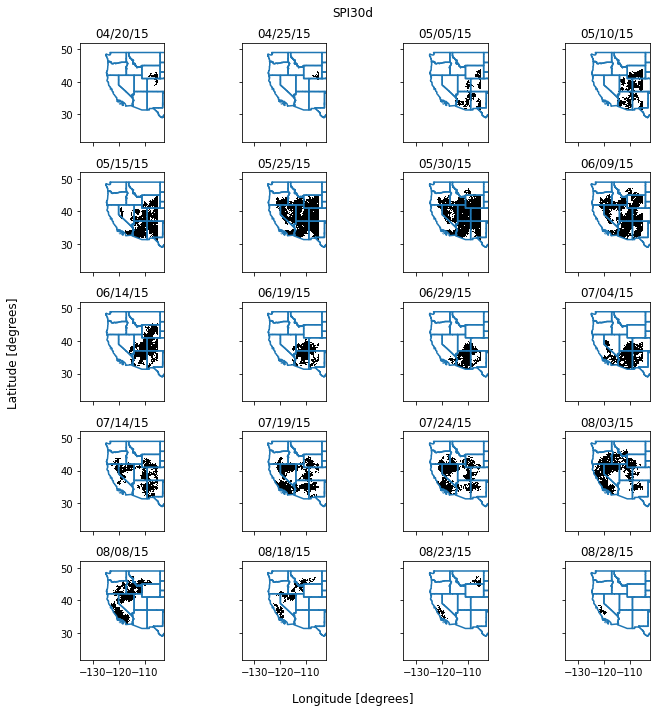

In [55]:
fig, axs = plt.subplots(5,4, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axs.ravel()):
    spi30d_array_da.isel(t=i).plot(ax=ax, cmap='Greys', add_colorbar=False)
    ax.set_title(pd.to_datetime(spi30d_array_da['t'].values[i]).strftime('%D'))
    ax.set_xlabel('')
    ax.set_ylabel('')
    us49.boundary.plot(ax=ax)
fig.supylabel('Latitude [degrees]')
fig.supxlabel('Longitude [degrees]')
fig.suptitle('SPI30d')
fig.set_facecolor('w')
plt.tight_layout()

In [44]:
spi180d_array_da = xr.DataArray(
    spi180d_array,
    dims = ['t', 'y', 'x'],
    coords = dict(
        x=paired_ds.x.values,
        y=paired_ds.y.values,
        t=paired_ds['SPI Date'].sel(index=slice(start_time, end_time)).values
    )
).rio.set_crs('EPSG:5070')
spi180d_array_da = spi180d_array_da.rio.reproject('EPSG:4326', nodata=0)

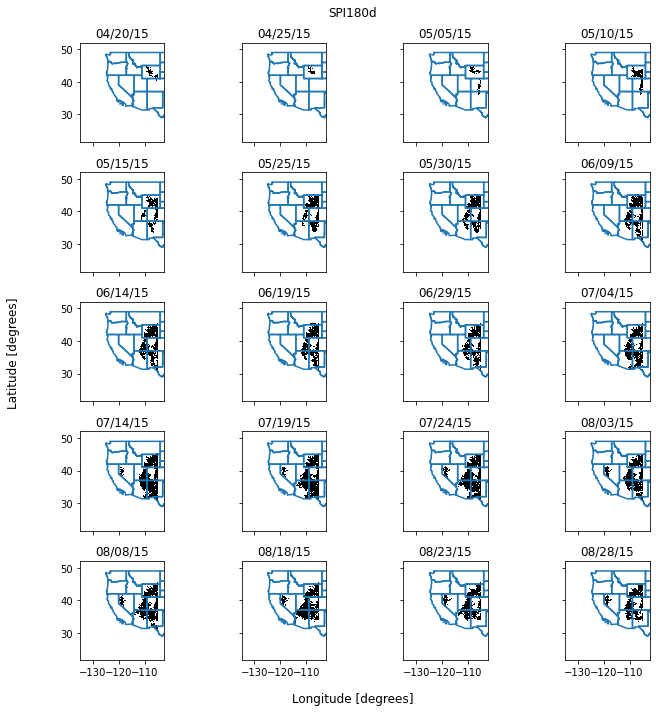

In [54]:
fig, axs = plt.subplots(5,4, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axs.ravel()):
    spi180d_array_da.isel(t=i).plot(ax=ax, cmap='Greys', add_colorbar=False)
    ax.set_title(pd.to_datetime(spi180d_array_da['t'].values[i]).strftime('%D'))
    ax.set_xlabel('')
    ax.set_ylabel('')
    us49.boundary.plot(ax=ax)
fig.supylabel('Latitude [degrees]')
fig.supxlabel('Longitude [degrees]')
fig.suptitle('SPI180d')
fig.set_facecolor('w')
plt.tight_layout()

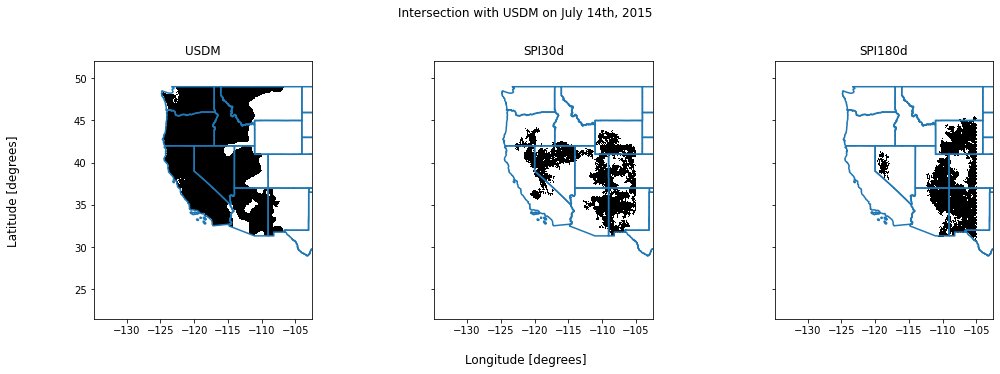

In [53]:
fig, axs = plt.subplots(1, 3, figsize=(15,5), sharey=True)

usdm_array_da.sel(t=intersect_time).plot(ax=axs[0], cmap='Greys', add_colorbar=False)
spi30d_array_da.sel(t=intersect_time).plot(ax=axs[1], cmap='Greys', add_colorbar=False)
spi180d_array_da.sel(t=intersect_time).plot(ax=axs[2], cmap='Greys', add_colorbar=False)

axs[0].set_title('USDM')
axs[1].set_title('SPI30d')
axs[2].set_title('SPI180d')

for ax in axs:
    ax.set_xlabel('')
    ax.set_ylabel('')
    us49.boundary.plot(ax=ax)

fig.supylabel('Latitude [degrees]')
fig.supxlabel('Longitude [degrees]')
fig.suptitle('Intersection with USDM on July 14th, 2015', y=1.01)
fig.set_facecolor('w')

plt.tight_layout()

In [59]:
def aa_da_trace_plot(
        aa, da_1, da_2, path_1, path_2,
        aa_name, name_1, name_2,
        aa_color, color_1, color_2,
        grid_to_area, dates, ax=None
):
    
    aa_all = dict()
    for pairing in aa:
        aa_all.update(pairing)

    pre_sort_times = np.hstack([list(aa_all.keys())])
    times = np.sort(pre_sort_times)
    plot_dates = dates[times]

    aa_plot_vals = np.hstack([aa_all[time] for time in times])
    da_1_vals = []
    for time in times:
        try:
            da_1_vals.append(da_1[time]*grid_to_area)
        except:
            da_1_vals.append(0)
    da_2_vals = []
    for time in times:
        try:
            da_2_vals.append(da_2[time]*grid_to_area)
        except:
            da_2_vals.append(0)

    areas_1 = dict()
    for node in path_1:
        if not node.time in areas_1.keys():
            areas_1[node.time] = 0
        areas_1[node.time] += len(node.coords)*grid_to_area
    areas_2 = dict()
    for node in path_2:
        if not node.time in areas_2.keys():
            areas_2[node.time] = 0
        areas_2[node.time] += len(node.coords)*grid_to_area

    if ax is None:
        __, ax = plt.subplots()

    ax.plot(plot_dates, aa_plot_vals*grid_to_area, label=aa_name, color=aa_color, marker='.')
    ax.plot(plot_dates, da_1_vals, label=f'{name_1} DA', color=color_1, marker='.')
    ax.plot(plot_dates, da_2_vals, label=f'{name_2} DA', color=color_2, marker='.')

    ax.plot(
        plot_dates,
        np.hstack([areas_1[time] for time in times]), label=f'{name_1} Area', color=color_1, linestyle='--', marker='.'
    )
    ax.plot(
        plot_dates,
        np.hstack([areas_2[time] for time in times]), label=f'{name_2} Area', color=color_2, linestyle='--', marker='.'
    )

    ax.set_ylabel('Area (km2)')
    ax.set_xlabel('Date')

    return ax

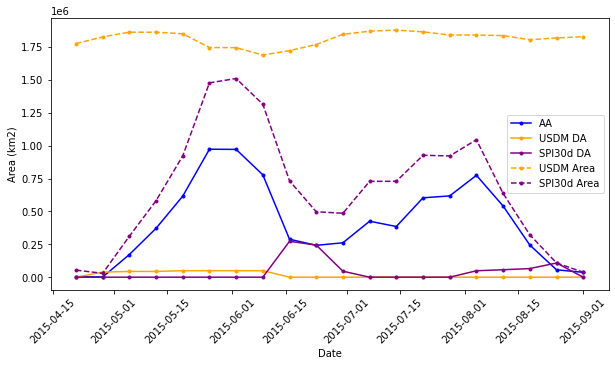

In [60]:
fig, ax = plt.subplots(figsize=(10,5))

ax = aa_da_trace_plot(
    aa_usdm_spi30d, da_usdm_spi30d, da_spi30d_usdm, 
    usdm_trace, spi30d_trace,
    'AA', 'USDM', 'SPI30d',
    'b', 'orange', 'purple',
    18.1, paired_ds['USDM Date'].values, ax
)
ax.legend()
ax.tick_params('x', rotation=45)
fig.set_facecolor('w')
#ax.set_yscale('symlog')
#ax.set_xlim(xmin, xmax)

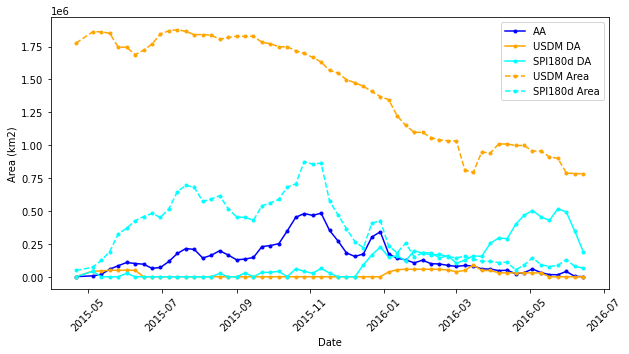

In [61]:
fig, ax = plt.subplots(figsize=(10,5))

ax = aa_da_trace_plot(
    aa_usdm_spi180d, da_usdm_spi180d, da_spi180d_usdm, 
    usdm_trace, spi180d_trace,
    'AA', 'USDM', 'SPI180d',
    'b', 'orange', 'cyan',
    18.1, paired_ds['USDM Date'].values, ax
)
ax.legend()
ax.tick_params('x', rotation=45)
fig.set_facecolor('w')
#ax.set_yscale('symlog')
#xmin, xmax = ax.get_xlim()

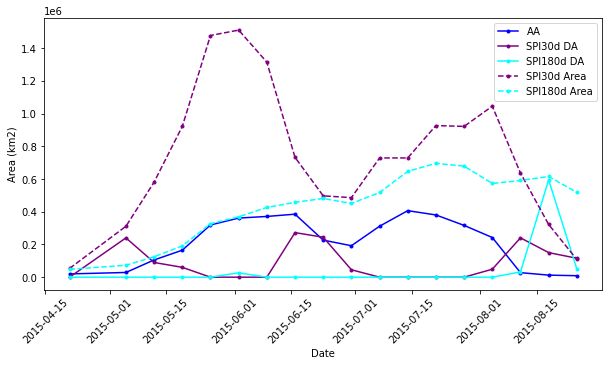

In [62]:
fig, ax = plt.subplots(figsize=(10,5))

ax = aa_da_trace_plot(
    aa_spi30d_spi180d, da_spi30d_spi180d, da_spi180d_spi30d, 
    spi30d_trace, spi180d_trace,
    'AA', 'SPI30d', 'SPI180d',
    'b', 'purple', 'cyan',
    18.1, paired_ds['USDM Date'].values, ax
)
ax.legend()
ax.tick_params('x', rotation=45)
fig.set_facecolor('w')
#ax.set_yscale('symlog')
#ax.set_xlim(xmin, xmax)